In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# laden der daten und Bereinigung
file_path = 'data.csv'  
data = pd.read_csv(file_path)
data = data.drop(columns=['Qualitaet_Byte', 'Qualitaet_Niveau'])

# Datum als index festlegen
data['Zeitstempel'] = pd.to_datetime(data['Zeitstempel'])
data.set_index('Zeitstempel', inplace=True)

# Liste der Stationen und Produkte erstellen
stations = data['SDO_ID'].unique()
products = data['Produkt_Code'].unique()
# Zeitfenster des gleitenden Durchschnitts festlegen
sma_window = 5

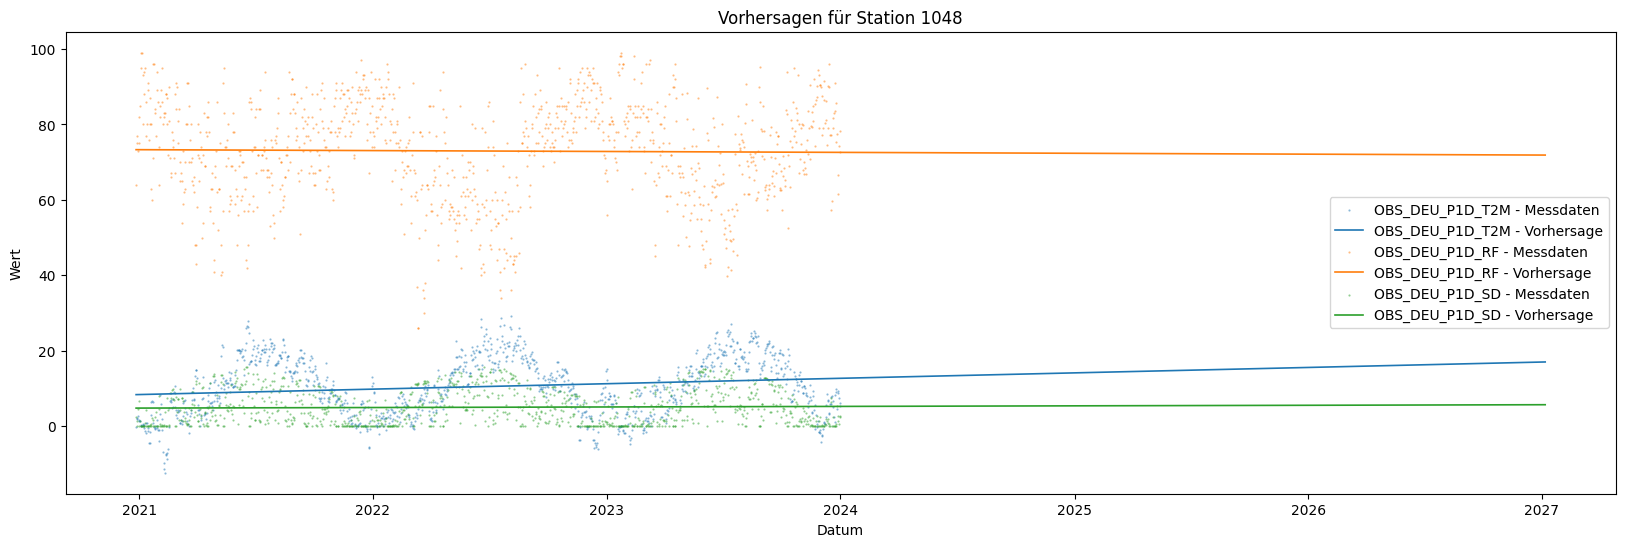

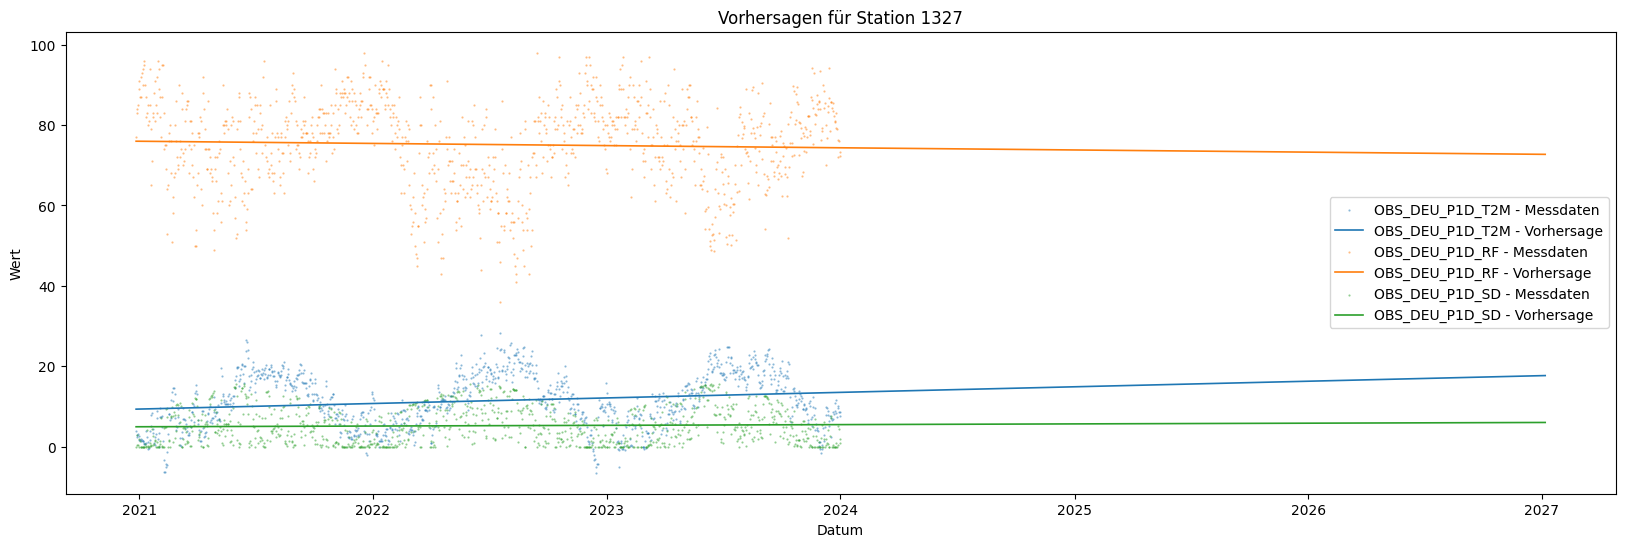

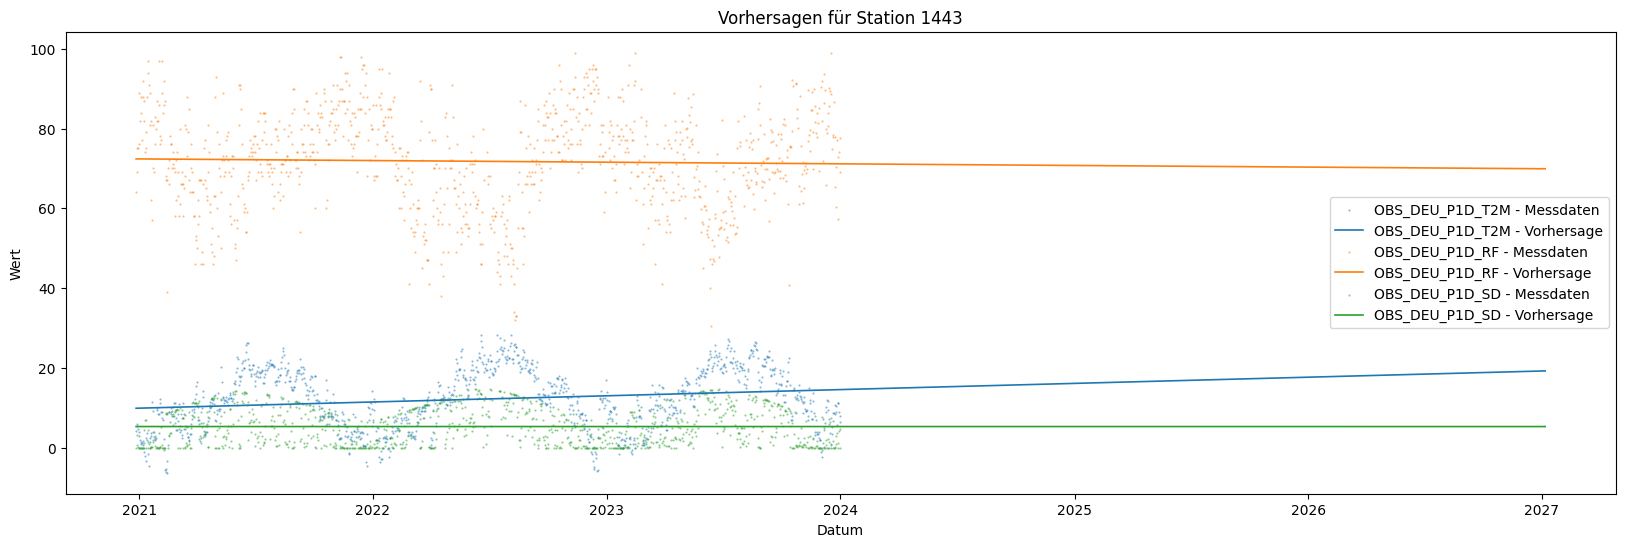

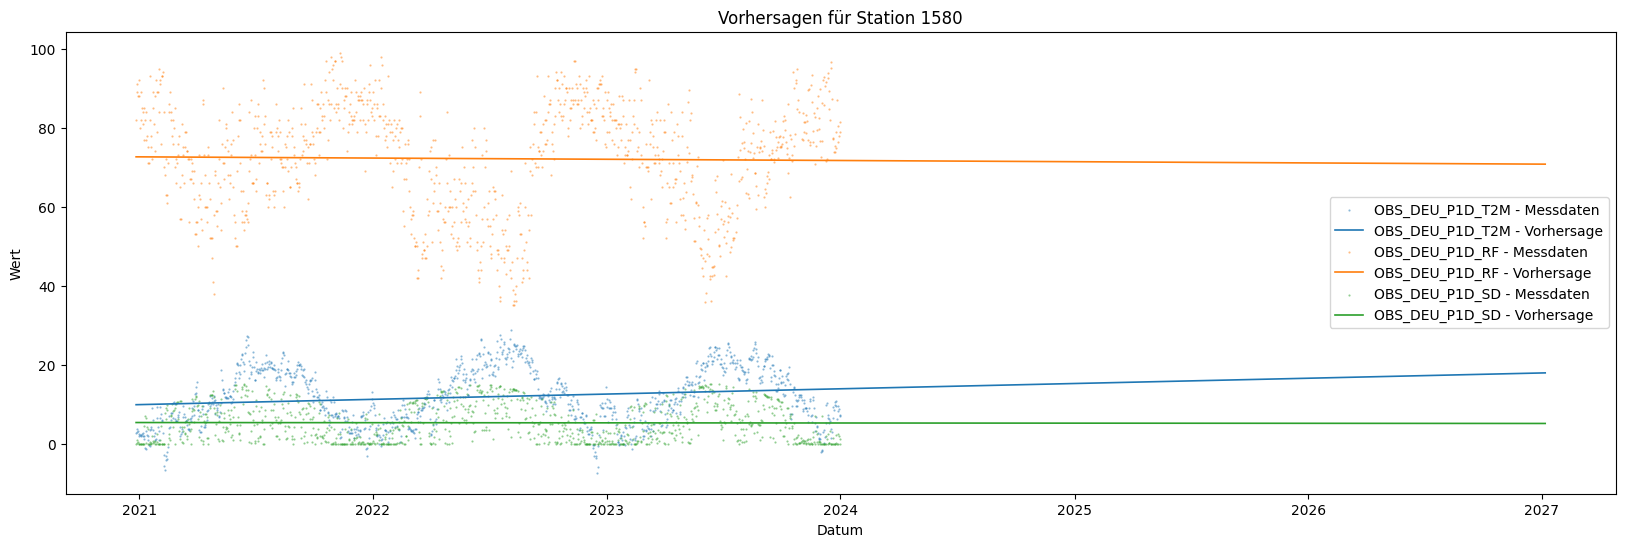

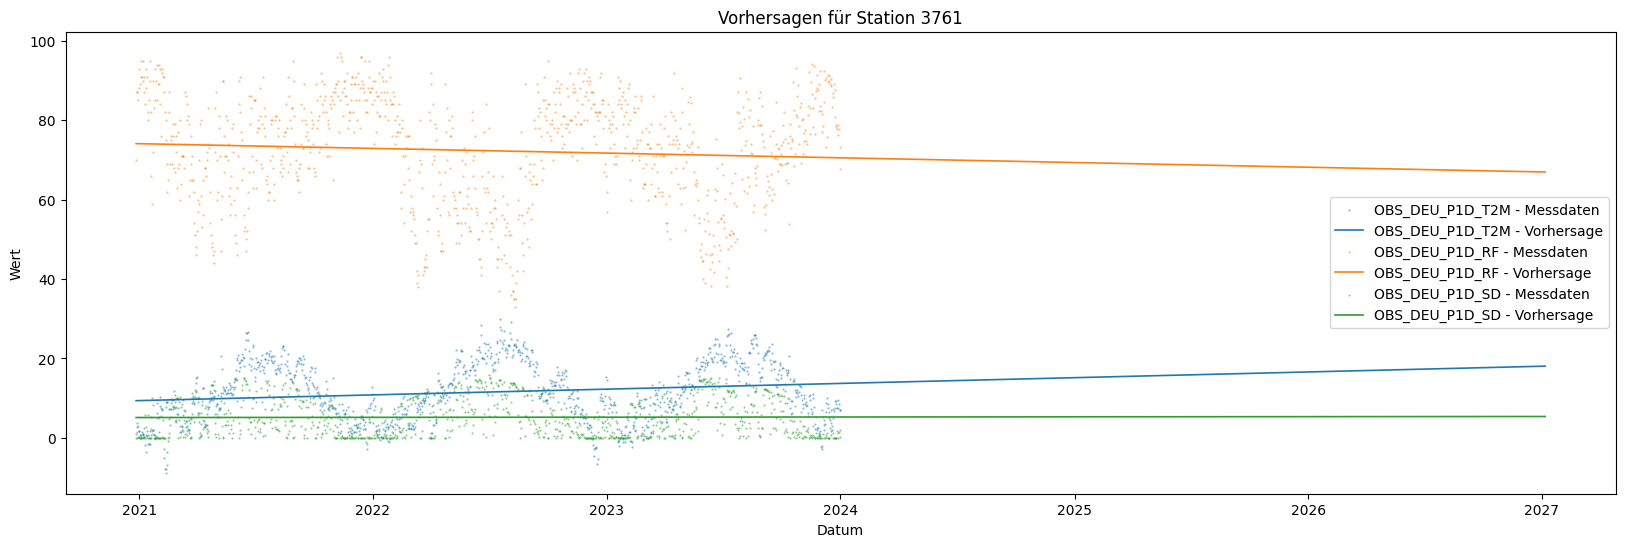

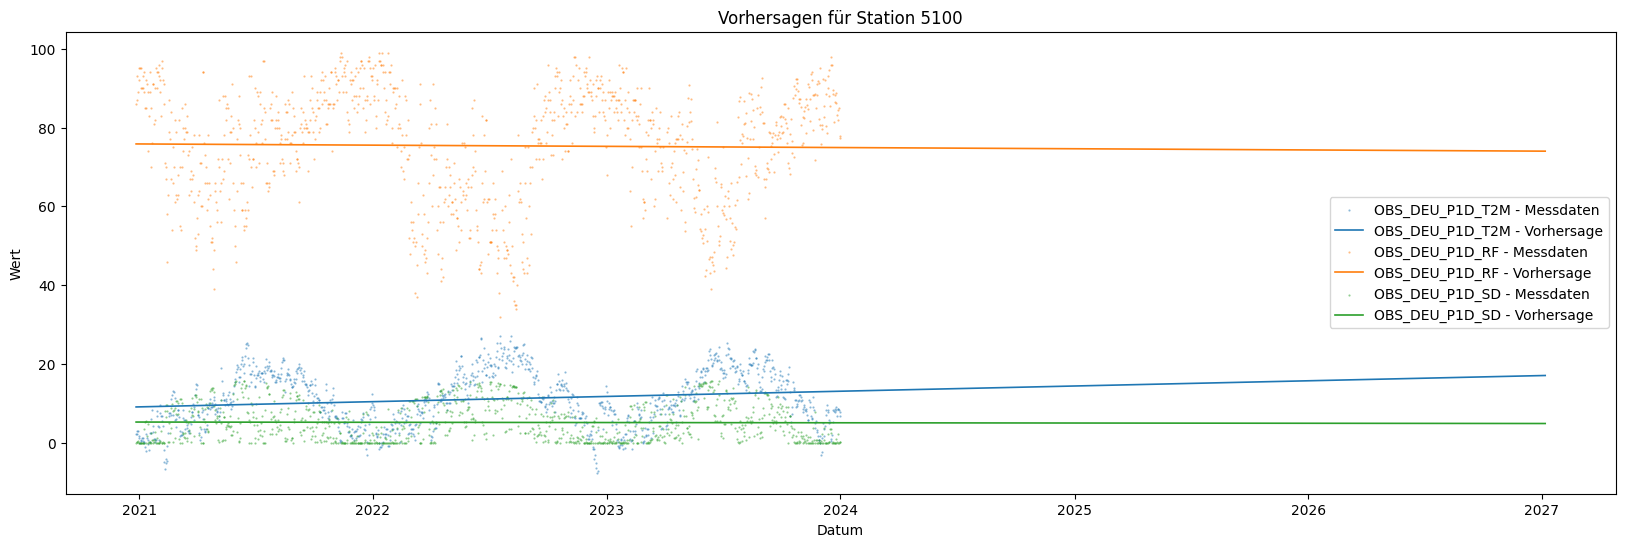

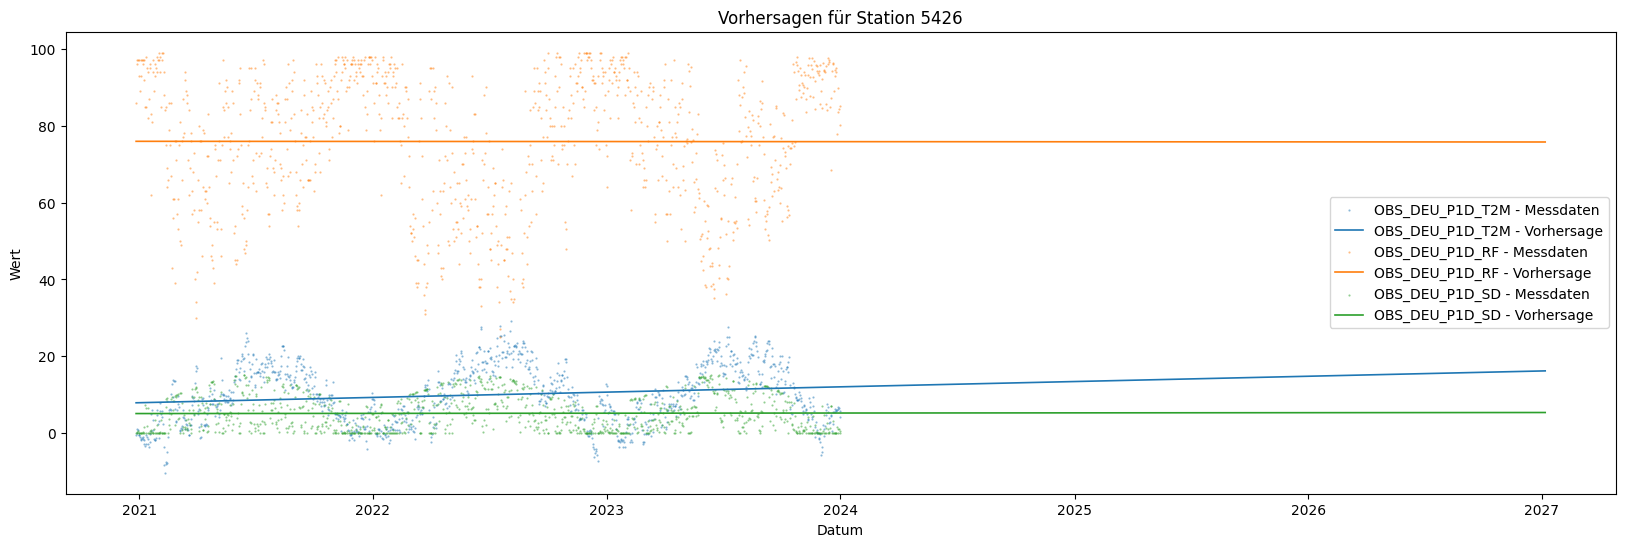

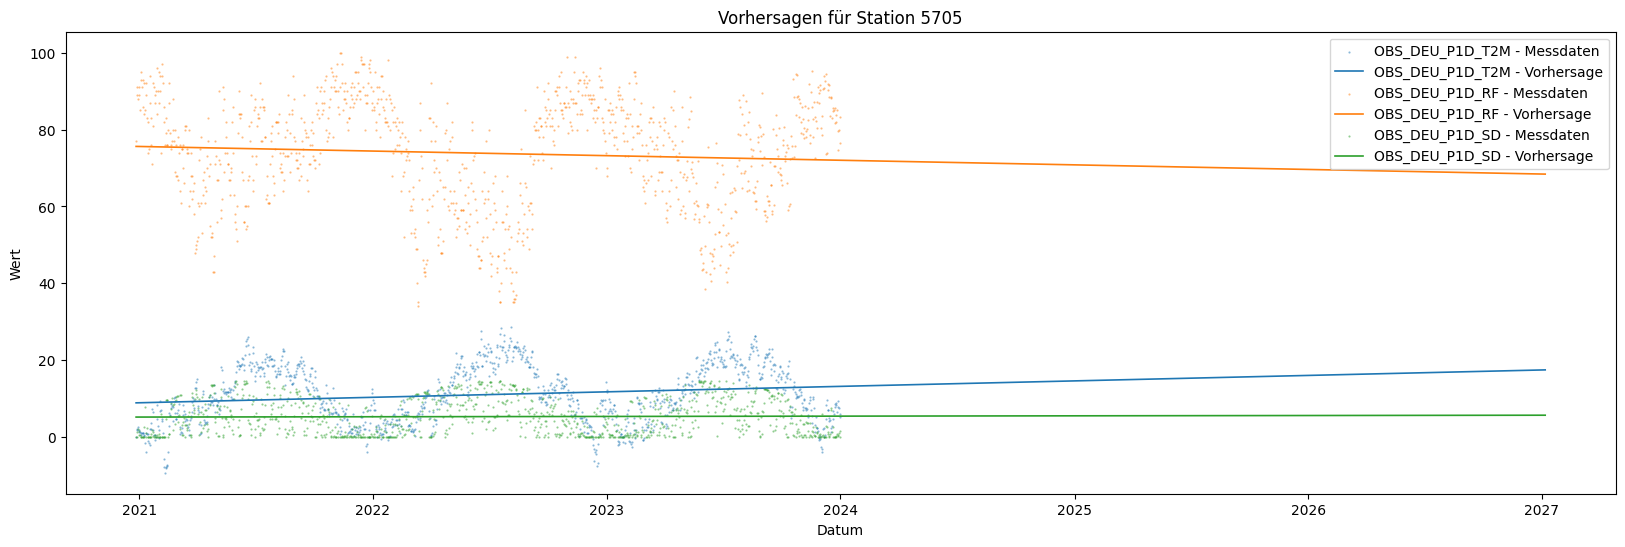

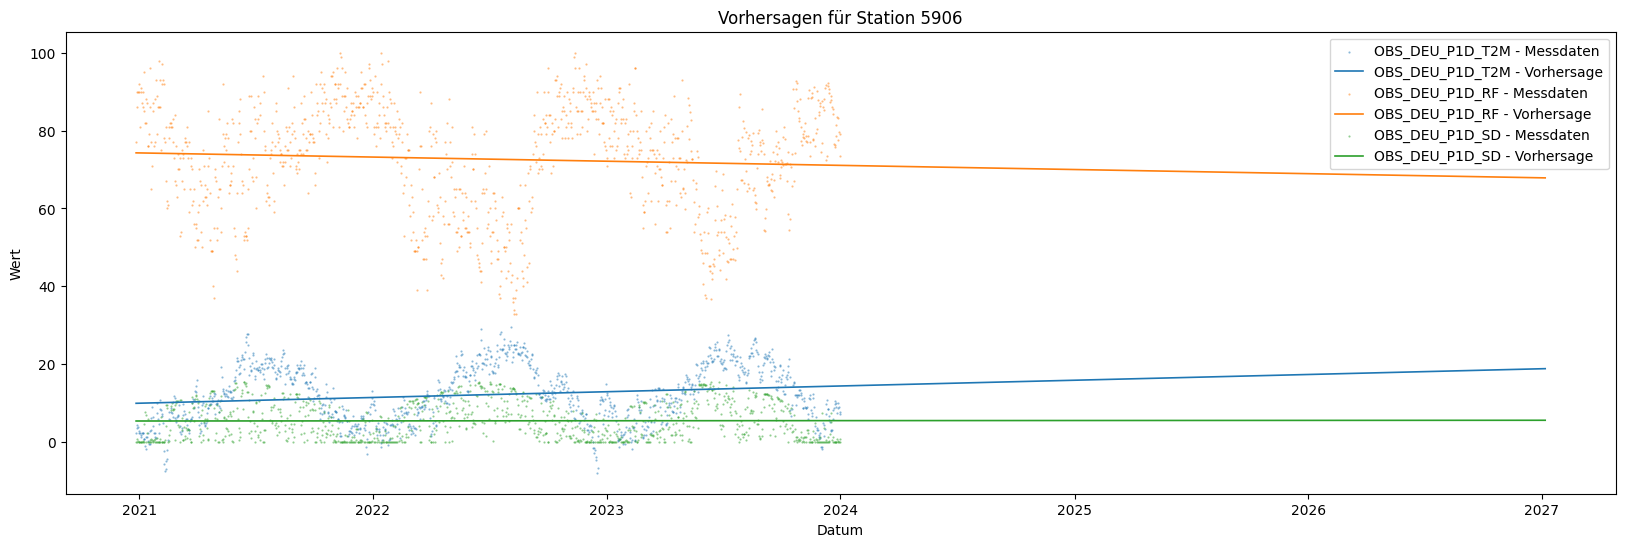

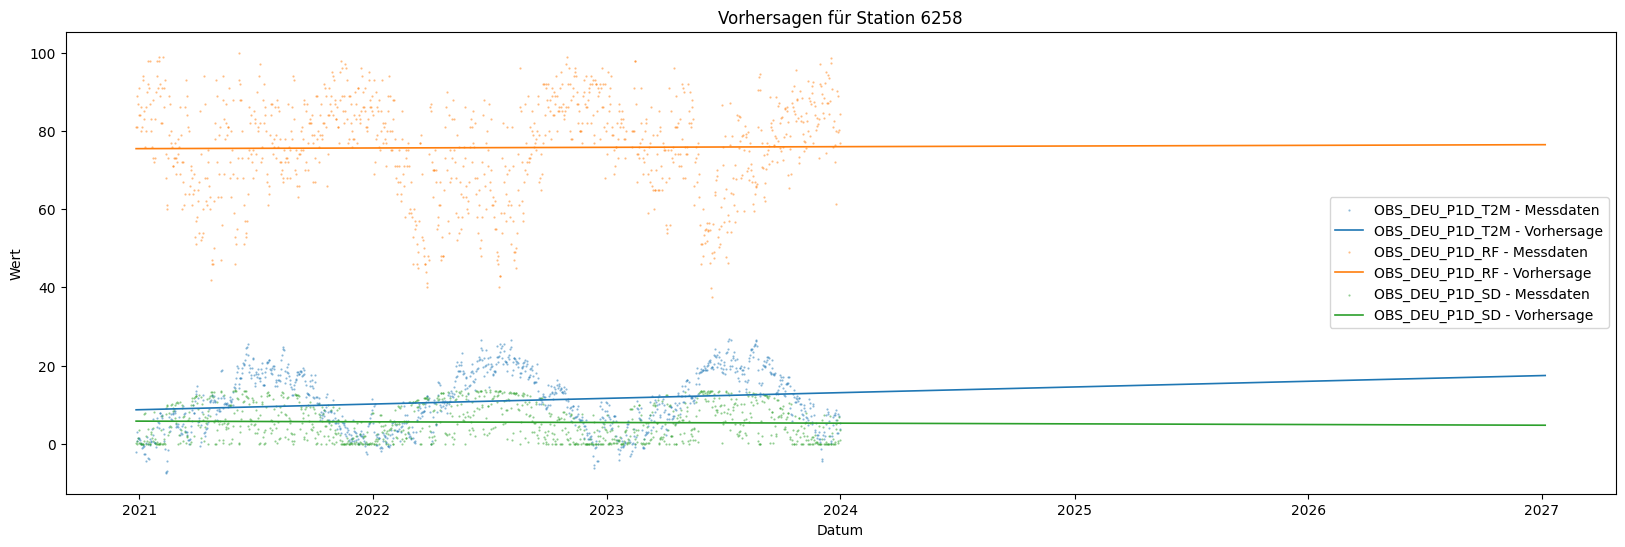

          Datum  Vorhergesagter_Wert  Wert     Produkt_Code  SDO_ID
0    2020-12-27                  NaN  -0.1  OBS_DEU_P1D_T2M    1048
1    2020-12-28                  NaN   1.9  OBS_DEU_P1D_T2M    1048
2    2020-12-29                  NaN   2.3  OBS_DEU_P1D_T2M    1048
3    2020-12-30                  NaN   2.6  OBS_DEU_P1D_T2M    1048
4    2020-12-31                  NaN   1.5  OBS_DEU_P1D_T2M    1048
...         ...                  ...   ...              ...     ...
2197 2027-01-02             4.747995   NaN   OBS_DEU_P1D_SD    6258
2198 2027-01-03             4.747519   NaN   OBS_DEU_P1D_SD    6258
2199 2027-01-04             4.747043   NaN   OBS_DEU_P1D_SD    6258
2200 2027-01-05             4.746567   NaN   OBS_DEU_P1D_SD    6258
2201 2027-01-06             4.746091   NaN   OBS_DEU_P1D_SD    6258

[66060 rows x 5 columns]


In [9]:
# Berechnung der linearen Regression der letzten 3 Jahre für jedes Produkt und jede Station

# Festlegen des Betrachtungszeitraums
latest_timestamp = data.index.max()
start_date = latest_timestamp - pd.DateOffset(years=3,days=5)
end_date = latest_timestamp + pd.DateOffset(years=3,days=5)
filtered_data = data[(data.index >= start_date) & (data.index <= end_date)]

future_predictions = []

# Schleife über alle Stationen und alle Produkte
for station in filtered_data['SDO_ID'].unique():
    station_data = filtered_data[filtered_data['SDO_ID'] == station]   
    plt.figure(figsize=(20, 6))    

    for product in products:
        product_data = station_data[station_data['Produkt_Code'] == product]
        
        # Festlegen der Regressionsparameter und Anwendung des linearen Regressionsmodel der kleinsten quadrate durch LinearRegression()
        X = (product_data.index - product_data.index[0]).days.values.reshape(-1, 1)
        y = product_data['Wert'].values        
        model = LinearRegression()
        model.fit(X, y)
        
        # Vorhersagen anhand des vorher erstellten Regressionsmodels
        future_dates = pd.date_range(start=product_data.index[0], end=end_date, freq='D')
        X_future = (future_dates - product_data.index[0]).days.values.reshape(-1, 1)
        y_pred_future = model.predict(X_future)
        
        # Kombination der Werte zu einem DataFrame
        combined_data = pd.DataFrame({'Datum': future_dates, 'Vorhergesagter_Wert': y_pred_future})
        combined_data.set_index('Datum', inplace=True)
        combined_data['Wert'] = np.nan
        combined_data.update(product_data['Wert'].rename('Wert'))
        
        # Trennen der Messwerte von den Prognosewerten
        combined_data['Vorhergesagter_Wert'] = combined_data['Vorhergesagter_Wert'].where(combined_data['Wert'].isna())
        combined_data['Wert'] = combined_data['Wert'].where(combined_data['Vorhergesagter_Wert'].isna())        
        combined_data.reset_index(inplace=True)
        combined_data['Produkt_Code'] = product
        combined_data['SDO_ID'] = station        
        
        future_predictions.append(combined_data)
        
        # Erstellen des aktuellen Plots       
        plt.scatter(product_data.index, y, label=f'{product} - Messdaten', alpha=0.5, s=0.3)
        plt.plot(future_dates, y_pred_future, label=f'{product} - Vorhersage', lw=1.2)
        
    # Grafische Darstellung der Messwerte und Vorhersage aller Plots
    plt.xlabel('Datum')
    plt.ylabel('Wert')
    plt.title(f'Vorhersagen für Station {station}')
    plt.legend()
    plt.show()

# Zusammenführen aller vorhergesagten Werte in einem DataFrame um alle Werte in einer Tabelle zu speichern
future_predictions_full = pd.concat(future_predictions)

# Anzeige und SPeichern der numerischen Werte
print(future_predictions_full)
future_predictions_full.set_index('Datum').to_csv('Vorhersage.csv', float_format='%.3f')

In [10]:
# Erstellen der Tabelle mit Standardabweichung der [sma_window]-tägigen gleitenden Durchschnitte und der normalisierten Standardabweichung derselben

results = []
scaler = MinMaxScaler()

for station in stations:
    station_data = data[data['SDO_ID'] == station].copy()    

    for product in station_data['Produkt_Code'].unique():
        product_data = station_data[station_data['Produkt_Code'] == product].copy()
        
        # Berechnen des gleitenden Durchschnitts dem Simple Moving Average (SMA) von 5 Tagen
        product_data['SMA'] = product_data['Wert'].rolling(window=sma_window).mean()
        
        # Berechnen der Standardabweichung der Werte in Bezug auf den SMA an jeder Position
        product_data['Standardabweichung_SMA'] = (product_data['Wert'] - product_data['SMA']).rolling(window=sma_window).std()
        product_data['Standardabweichung_SMA_normalisiert'] =  scaler.fit_transform(product_data[['Standardabweichung_SMA']])
              
        results.append(product_data)

# Zusammenführen aller Ergebnisse in einem DataFrame
results = pd.concat(results)
# Speichern der Tabelle als CSV-Datei 
results.reset_index(inplace=True)
results = results[['Zeitstempel', 'Produkt_Code', 'SDO_ID', 'Wert', 'SMA', 'Standardabweichung_SMA','Standardabweichung_SMA_normalisiert']]
results.to_csv('Stationsdaten_sma_std.csv', index=False, float_format='%.4f')

print(results)


       Zeitstempel     Produkt_Code  SDO_ID   Wert     SMA  \
0       2014-01-01  OBS_DEU_P1D_T2M    1048  2.200     NaN   
1       2014-01-02  OBS_DEU_P1D_T2M    1048  3.500     NaN   
2       2014-01-03  OBS_DEU_P1D_T2M    1048  5.800     NaN   
3       2014-01-04  OBS_DEU_P1D_T2M    1048  6.400     NaN   
4       2014-01-05  OBS_DEU_P1D_T2M    1048  5.400  4.6600   
...            ...              ...     ...    ...     ...   
109312  2023-12-28   OBS_DEU_P1D_SD    6258  0.717  3.1902   
109313  2023-12-29   OBS_DEU_P1D_SD    6258  0.117  3.1302   
109314  2023-12-30   OBS_DEU_P1D_SD    6258  6.867  3.5002   
109315  2023-12-31   OBS_DEU_P1D_SD    6258  0.950  2.9336   
109316  2024-01-01   OBS_DEU_P1D_SD    6258  3.433  2.4168   

        Standardabweichung_SMA  Standardabweichung_SMA_normalisiert  
0                          NaN                                  NaN  
1                          NaN                                  NaN  
2                          NaN               

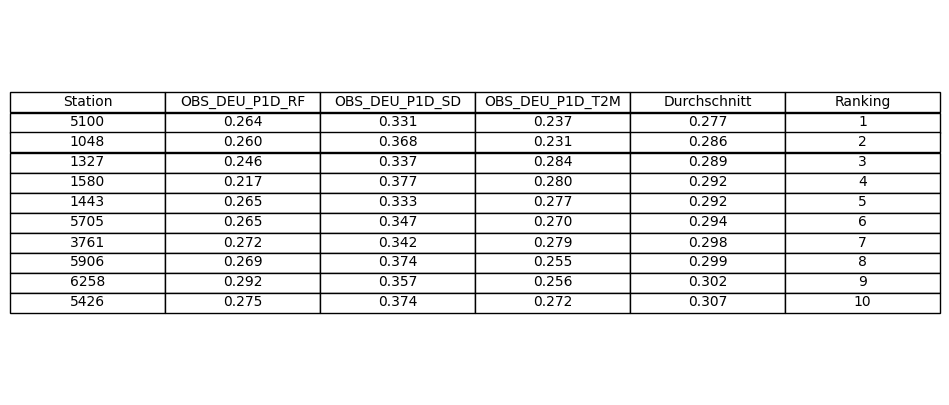

Station mit der geringsten Variabilität: 5100


In [11]:
#Erstellen des gleitenden Durchschnitts der letzten 5 Werte: SMA(5) und daruf basierend die Standardabweichung und deren normalisierte Form

results = []
# Initialisieren des Scalers zur Normalisierung der STD_SMA(5) Werte
scaler = MinMaxScaler()

# Iterieren über jede Station
for station in stations:
    station_data = data[data['SDO_ID'] == station].copy()
    
    # Iterieren über jedes Produkt
    for product in station_data['Produkt_Code'].unique():
        product_data = station_data[station_data['Produkt_Code'] == product].copy()
        
        # Berechnen des Simple Moving Average (SMA) von 5 Tagen
        product_data['SMA_5'] = product_data['Wert'].rolling(window=sma_window).mean()        
        # Berechnen der Standardabweichung der Werte in Bezug auf den SMA an jeder Position
        product_data['Standardabweichung_SMA'] = (product_data['Wert'] - product_data['SMA_5']).rolling(window=sma_window).std()        
        
        # Normalisieren der Standardabweichung
        product_data['Standardabweichung_SMA_normalisiert'] = scaler.fit_transform(product_data[['Standardabweichung_SMA']])        
       
        results.append(product_data)

# Zusammenführen aller Ergebnisse in einem DataFrame
results = pd.concat(results)

# Initialisieren eines DataFrames für die Mediane
median_df = pd.DataFrame()

# Iterieren über jede Station für den Boxplot
for station in results['SDO_ID'].unique():
    # Daten für die aktuelle Station filtern
    station_data = results[results['SDO_ID'] == station]
    
    # Berechnen der Mediane der normalisierten Standardabweichungen für jedes Produkt
    medians = station_data.groupby('Produkt_Code')['Standardabweichung_SMA_normalisiert'].median()
    median_df[station] = medians

# Darstellung der Stationen als Index
median_df = median_df.T
# Berechnen des Durchschnitts der Standardabweichungen für jede Station
median_df['Durchschnitt'] = median_df.mean(axis=1)
# Sortieren der Tabelle nach dem Durchschnitt
median_df = median_df.sort_values(by='Durchschnitt')
# Einfügen eines Index von 1 bis 10
median_df['Ranking'] = range(1, len(median_df) + 1)
# Zurücksetzen des Index und Umbenennen der ersten Spalte
median_df.reset_index(inplace=True)
median_df.rename(columns={'index': 'Station'}, inplace=True)

# Speichern der Tabelle 
median_df.to_csv('Ergebniss.csv', index=False, float_format='%.4f')
# Anzeige des Rankings und der Stationen ohne Nachkommastellen
median_df['Ranking'] = median_df['Ranking'].astype(int).astype(str)
median_df['Station'] = median_df['Station'].astype(str)

# Daten-Spalten auf zwei Nachkommastellen formatieren
for col in median_df.columns:
    if col not in ['Ranking', 'Station']:
        median_df[col] = median_df[col].apply(lambda x: f"{x:.3f}")

# Daten als Tabelle anzeigen
fig, ax = plt.subplots(figsize=(10, len(median_df) * 0.5))  
ax.axis('off')  

# Tabelle erstellen
table = ax.table(cellText=median_df.values, colLabels=median_df.columns, cellLoc='center', loc='center')

# Tabelle anpassen
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Erstellen einer Variable für die nächste Zelle
std_median_data = results

#Anzeigen der Resultate
plt.show() 
# bei Änderungen der Parameter wird stets die aktuell beste Station angezeigt
print(f"Station mit der geringsten Variabilität: {median_df.iloc[0]['Station']}")

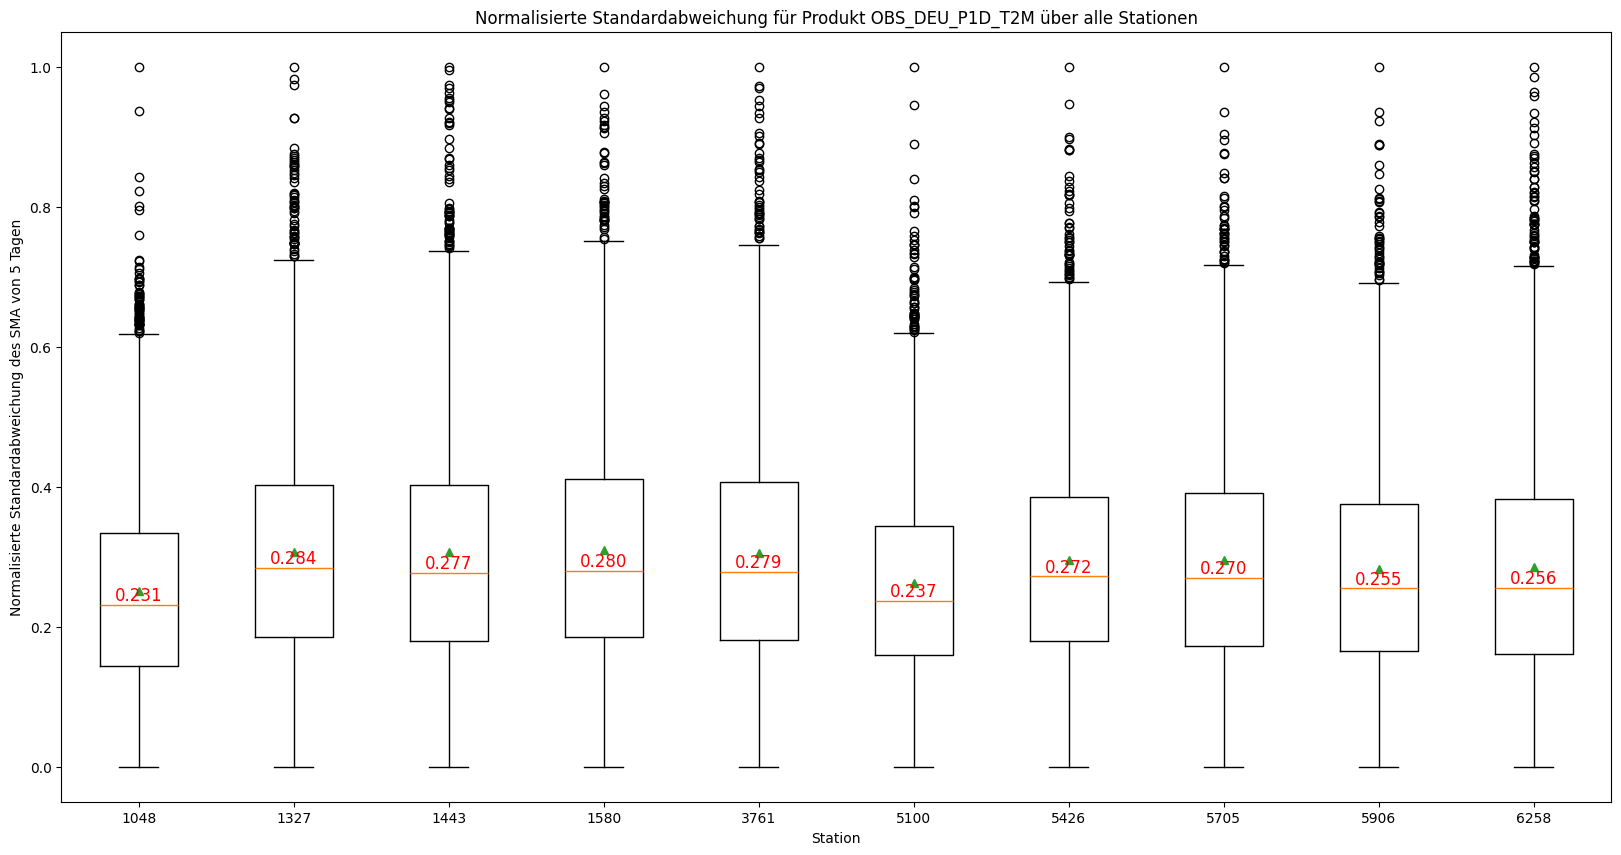

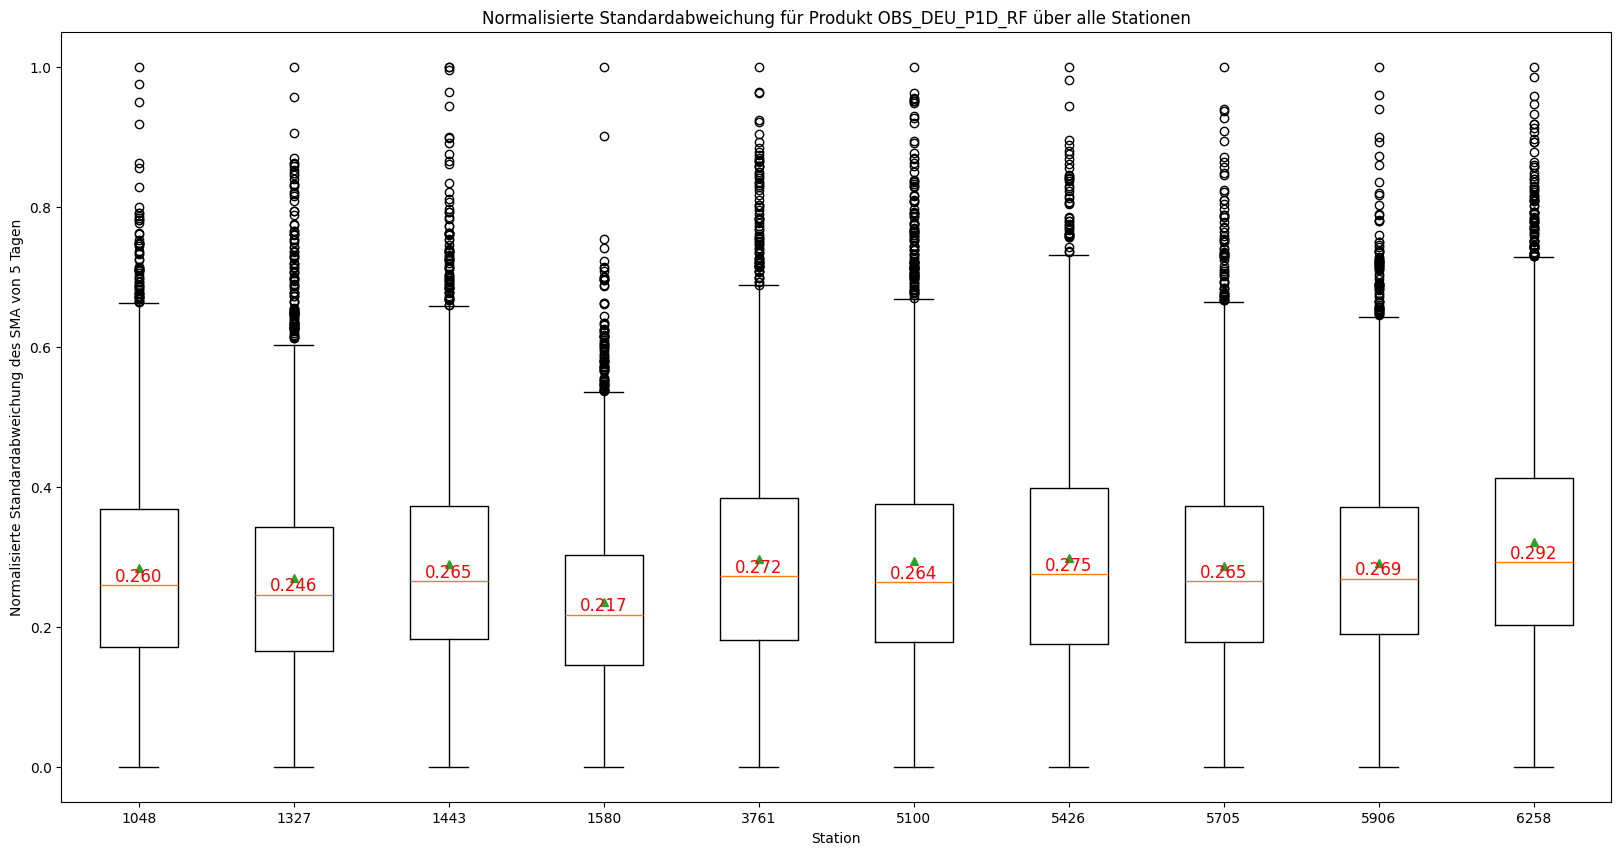

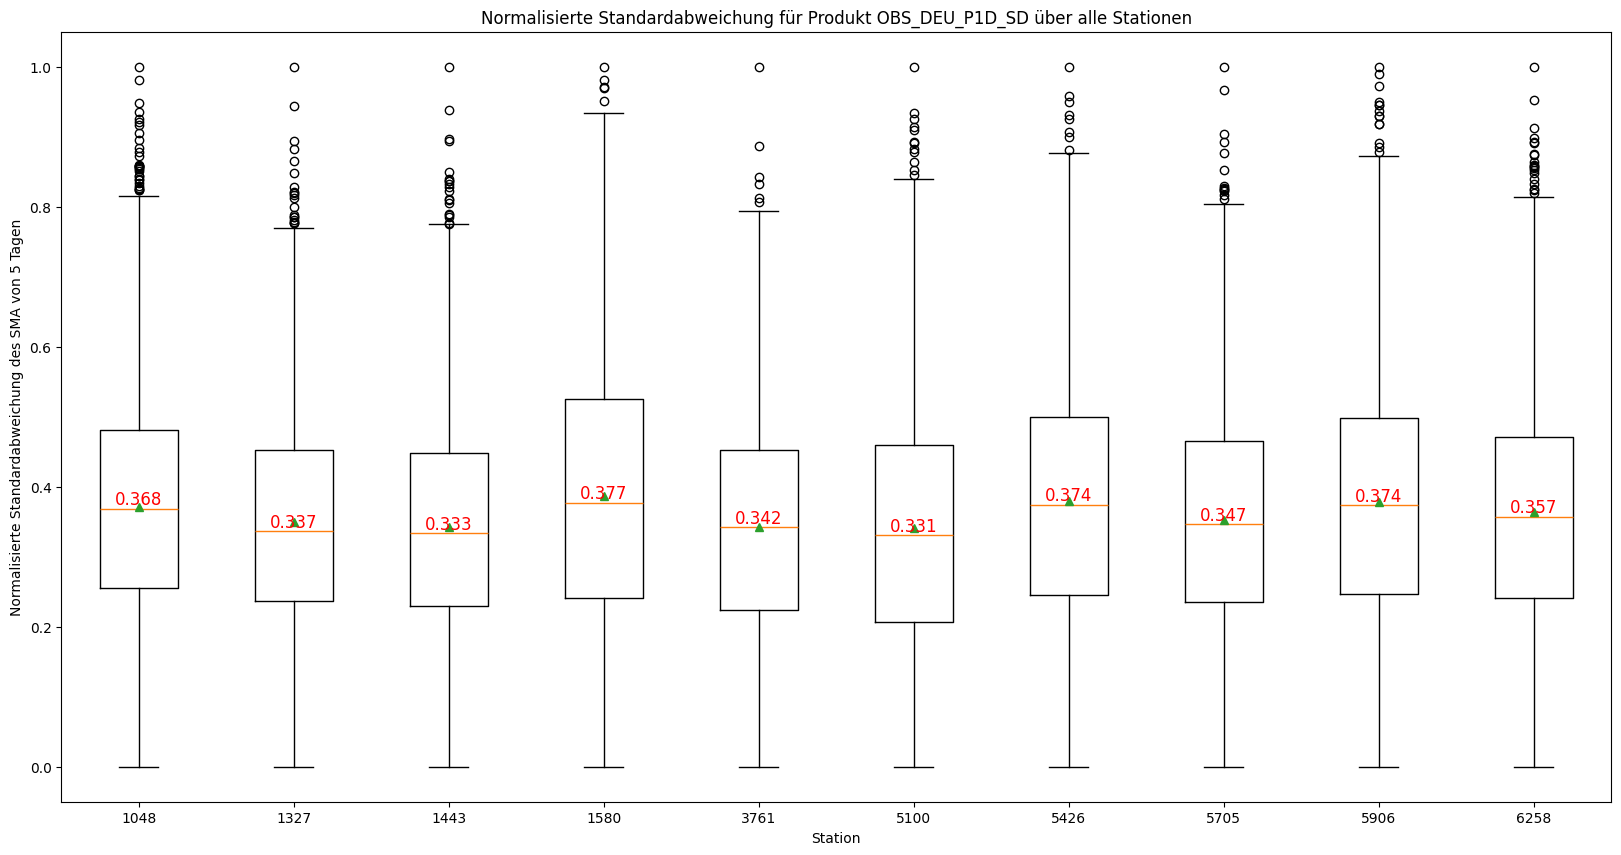

In [12]:
# Erstellen des Boxplots für jedes Produkt

for product in std_median_data['Produkt_Code'].unique():
    plt.figure(figsize=(20, 10))    
    
    product_data = std_median_data[std_median_data['Produkt_Code'] == product]
    
    # Definieren des Boxplots: zu jeder Station werden die normalisierten Standardabweichungen des SMA(sma_window) des Produkts des aktuellen Schleifendurchlaufs erstellt und die leeren Felder verworfen    
    boxplot_data = [product_data[product_data['SDO_ID'] == station]['Standardabweichung_SMA_normalisiert'].dropna() for station in stations]    
    plt.boxplot(boxplot_data, tick_labels=stations, showmeans=True)
    
    # Anzeigen der Median Werte im Diagramm
    for i in range(len(stations)):
        median_value = np.median(boxplot_data[i])
        plt.text(i + 1, median_value, f'{median_value:.3f}', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='red')
    # Formatierung des Diagramms
    plt.xlabel('Station')
    plt.ylabel(f'Normalisierte Standardabweichung des SMA von {sma_window} Tagen')
    plt.title(f'Normalisierte Standardabweichung für Produkt {product} über alle Stationen')
    plt.show()
